# Setup

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cloudpickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# Get original experiments

In [3]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


## Extend the experiment df with the experiment processed results

In [4]:
import numpy as np 

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

def smooth_spectrum(x, y, window=4):
    y = np.array(y)
    y_smooth = np.zeros_like(y)
    for i in range(len(y)):
        if i < window:
            y_smooth[i] = np.mean(y[:i+window])
        elif i > len(y) - window:
            y_smooth[i] = np.mean(y[i-window:])
        else:
            y_smooth[i] = np.mean(y[i-window:i+window])
    return x, y_smooth.tolist()

In [5]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            x, y = smooth_spectrum(x, y)
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            x, y = smooth_spectrum(x, y)
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
            abs_s = df[df['nm'] == 430][' A'].values[0]
            fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
            fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
            qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
        else:
            print(f"File not available: Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = -1

        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    'QY': [qy],
                                    # 'Distance_peaks': [peaks[1]-peaks[0]],
                                    # 'ratioP2P1': [areas[1]/areas[0]],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm]
                                    }) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-10.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/0-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-1-180.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-180.csv


## Create dataset with experiments and entire espectra points

In [6]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/fl_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')

new_columns = ['Wavelength(nm)', 'Absorbance', 'Absorbance_norm']
with open('Data/abs_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')
            else:
                pass

## Process all procedures (original and new ones)

In [7]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
# df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-3]
features, labels

(Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
        'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
        'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
       dtype='object'),
 Index(['Peak1', 'Peak2', 'Area1', 'Area2', 'QY', 'Fl_Wavelengths',
        'Fluorescence', 'Fluorescence_norm'],
       dtype='object'))

In [8]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

prompts = []
labels_peak1 = []
labels_peak2 = []
labels_auc1 = []
labels_auc2 = []
labels_qy   = []
labels_f    = []
for i, r in df.iterrows():
    if r['QY']*r['Area2'] < 0.0:
        continue
    s = r[features].to_dict()
    prompts.append(prompt_template.format(**s))
    labels_peak1.append(r['Peak1'])
    labels_peak2.append(r['Peak2'])
    labels_auc1.append(r['Area1'])
    labels_auc2.append(r['Area2'])
    labels_qy.append(r['QY'])
    labels_f.append(r['QY']*r['Area2'])

In [12]:
def process_input(fl_data, abs_data, is_val_data = False):
    # Process fluorescence data
    lines = fl_data.readlines()
    x = []
    y = []
    for line in lines:
        x.append(float(line.split()[0]))
        y.append(float(line.split()[1]))
    x, y = smooth_spectrum(x, y)
    fl_int_norm = [yi/max(y) for yi in y]
    fl_auc_total = get_area_under_peaks(x, y)
    peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
    fl_wvl, fl_int = x[:], y[:]

    # Process absorbance data
    df = pd.read_csv(abs_data)
    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
    x, y = smooth_spectrum(x, y)
    abs_int_norm = [yi/max(y) for yi in y]
    abs_auc_total = get_area_under_peaks(x, y)
    abs_wvl, abs_int = x[:], y[:]
    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
    abs_s = df[df['nm'] == 430][' A'].values[0]
    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
    if is_val_data:
        fl_r, abs_r, n_r = 9453221.02, 0.039083, 1.375
    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2

    return peaks[0], peaks[1], areas[0], areas[1], qy, qy*areas[1]

pool_results = pd.DataFrame()

BO_NLP = {
    "M1-R1" : "Stock nanoplatelets have dimensions 46.3494 nm by 8.095 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 5.0 % Ag doping requires 45.3 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M1-R2" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 0.25 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M1-R3" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 0.25 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M1-R4" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M1-R5" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.2 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    # "M2-R1" : "", # <- Was not performed due to lack of material with the proposed dimensions #
    "M2-R2" : "Stock nanoplatelets have dimensions 46.3494 nm by 8.0954 nm (375.21nm2) and the optical density of 100x hexanes dilution of stock is 0.31% recorded at 511nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 13.372 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M2-R3" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm (274.8nm2) and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 510nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M2-R4" : "Stock nanoplatelets have dimensions 36.9 nm by 7.44 nm (274.8nm2) and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 510nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 5.0 % Ag doping requires 11.8 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M2-R5" : "Stock nanoplatelets have dimensions 30.928 nm by 7.955 nm (246.042nm2) and the optical density of 100x hexanes dilution of stock is 0.3% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.5633 mL of MeOH and 2.2253 mL of water. 1.0 % Ag doping requires 4.2 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "M3-R1" : "Stock nanoplatelets have dimensions 19.835 nm by 14.762 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M3-R2" : "Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M3-R3" : "Stock nanoplatelets have dimensions 29.529 nm by 8.737 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M3-R4" : "Stock nanoplatelets have dimensions 19.835 nm by 14.762 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M3-R5" : "Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "M4-R1": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 14.000 mg of silver acetate in 85.589 mL of MeOH and 34.236 mL of water. 10.000 % Ag doping requires 344.528 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M4-R2": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 14.000 mg of silver acetate in 85.589 mL of MeOH and 34.236 mL of water. 5.000 % Ag doping requires 43.066 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M4-R3": "Stock nanoplatelets have dimensions 30.594 nm by 8.897 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 2.000 % Ag doping requires 9.388 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M4-R5": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 86.132 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "M5-R1": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 6.768 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R2": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 80.991 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes",
    "M5-R3": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 53.209 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R4": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 106.418 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R5": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 2.000 % Ag doping requires 3.780 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R6": "prompt: Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 27.072 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R7": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 14.000 mg of silver acetate in 9.985 mL of MeOH and 3.994 mL of water. 5.000 % Ag doping requires 3.104 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R8": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 10.000 % Ag doping requires 18.898 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "M5-R9": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 2.000 % Ag doping requires 10.829 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #

    }

BO_NLP_pred = {
    "M1-R1" : 0.192,
    "M1-R2" : 0.08,
    "M1-R3" : 0.08,
    "M1-R4" : 0.04,
    "M1-R5" : 0.086,
    "M2-R1" : 0.202,
    "M2-R2" : 0.134,
    "M2-R3" : 0.150,
    "M2-R4" : 0.138,
    "M2-R5" : 0.158,
    "M3-R1" : 0.178,
    "M3-R2" : 0.170,
    "M3-R3" : 0.088,
    "M3-R4" : 0.072,
    "M3-R5" : 0.076,
    "M4-R1" : 0.094,
    "M4-R2" : 0.0744,
    "M4-R3" : 0.098,
    "M4-R5" : 0.144,
    "M5-R1" : 0.02024,
    "M5-R2" : 0.024,
    "M5-R3" : 0.0332,
    "M5-R4" : 0.244,
    "M5-R5" : 0.252,
    "M5-R6" : 0.226,
    "M5-R7" : 0.468,
    "M5-R8" : 0.446,
    "M5-R9" : 0.32,
}

for r in BO_NLP.keys():
    #check if file exists
    if not os.path.exists(f"Data/proposed_trials/NLP2/{r}_corrected.txt"):
        print(f"File not available: Data/proposed_trials/NLP2/{r}_corrected.txt")
        continue
    if not os.path.exists(f"Data/proposed_trials/NLP2/{r}.csv"):
        print(f"File not available: Data/proposed_trials/NLP2/{r}.csv")
        continue
    
    with open(f"Data/proposed_trials/NLP/{r}.txt", "r", encoding='utf-8-sig') as fl_data:
        with open(f"Data/proposed_trials/NLP/{r}.csv", "r", encoding='utf-8-sig') as abs_data:
            prompt = BO_NLP[r]
            is_val_data = False
            if r.startswith('M5'):
                is_val_data = True
            peak1, peak2, area1, area2, qy, completion = process_input(fl_data, abs_data, is_val_data = is_val_data)
            prompts.append(prompt)
            labels_peak1.append(peak1)
            labels_peak2.append(peak2)
            labels_auc1.append(area1)
            labels_auc2.append(area2)
            labels_qy.append(qy)
            labels_f.append(completion)
            print(completion)
            new_entry = pd.DataFrame({
                "Experiment": [r],
                'prompt': [prompt],
                "prediction": [BO_NLP_pred[r]],
                'completion': [completion],
                'peak1': [peak1],
                'peak2': [peak2],
                'area1': [area1],
                'area2': [area2],
                'QY': [qy],
            })
            pool_results = pd.concat([pool_results, new_entry], ignore_index=True)

pool_results

0.0754133733366124
0.041410218742160575
0.1123888933428413
0.15495249092264618
0.1417984039717462
0.07747630976804684
0.13675340728181973
0.05670549021950816
0.06882354925280722
File not available: Data/proposed_trials/NLP2/M3-R1_corrected.txt
0.10353343235884162
0.10528375922331924
File not available: Data/proposed_trials/NLP2/M3-R4_corrected.txt
0.11447089186622926
0.10288587683658465
0.133647761580258
0.07506287226530123
0.16872969988101516
0.07404765796610471
0.08132891725985263
0.08346286163762115
0.06448750758321845
0.053038048156440774
0.09387482367353168
0.07661757643722769
0.07238287328069311
0.09338118290486859


,Experiment,prompt,prediction,completion,peak1,peak2,area1,area2,QY
0,M1-R1,Stock nanoplatelets have dimensions 46.3494 nm...,0.19200,0.075413,512.0,650.0,0.037484,0.740236,0.101877
1,M1-R2,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,0.041410,511.0,550.0,0.958160,0.035460,1.167806
2,M1-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,0.112389,510.0,619.0,0.840491,0.142027,0.791318
3,M1-R4,Stock nanoplatelets have dimensions 36.9235 nm...,0.04000,0.154952,510.0,625.0,0.290026,0.616704,0.251259
4,M1-R5,Stock nanoplatelets have dimensions 36.9235 nm...,0.08600,0.141798,511.0,610.0,0.653160,0.311720,0.454890
5,M2-R2,Stock nanoplatelets have dimensions 46.3494 nm...,0.13400,0.077476,512.0,641.0,0.048227,0.804837,0.096263
6,M2-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.15000,0.136753,510.0,630.0,0.431375,0.506916,0.269775
7,M2-R4,Stock nanoplatelets have dimensions 36.9 nm by...,0.13800,0.056705,511.0,649.0,0.030940,0.765503,0.074076
8,M2-R5,Stock nanoplatelets have dimensions 30.928 nm ...,0.15800,0.068824,512.0,599.0,0.755387,0.215545,0.319301
9,M3-R2,Stock nanoplatelets have dimensions 31.121 nm ...,0.17000,0.103533,511.0,610.0,0.816542,0.162114,0.638646


In [50]:
# pool_results.drop(index=[i for i in range(12)], axis=0, inplace=True)

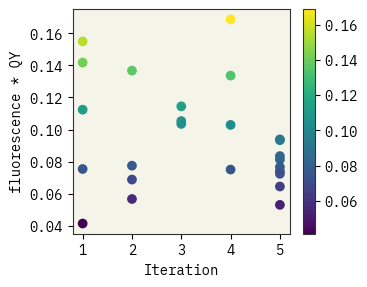

,Experiment,prompt,prediction,completion,peak1,peak2,area1,area2,QY,x,y
0,M1-R1,Stock nanoplatelets have dimensions 46.3494 nm...,0.19200,0.075413,512.0,650.0,0.037484,0.740236,0.101877,1,0.075413
1,M1-R2,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,0.041410,511.0,550.0,0.958160,0.035460,1.167806,1,0.041410
2,M1-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,0.112389,510.0,619.0,0.840491,0.142027,0.791318,1,0.112389
3,M1-R4,Stock nanoplatelets have dimensions 36.9235 nm...,0.04000,0.154952,510.0,625.0,0.290026,0.616704,0.251259,1,0.154952
4,M1-R5,Stock nanoplatelets have dimensions 36.9235 nm...,0.08600,0.141798,511.0,610.0,0.653160,0.311720,0.454890,1,0.141798
5,M2-R2,Stock nanoplatelets have dimensions 46.3494 nm...,0.13400,0.077476,512.0,641.0,0.048227,0.804837,0.096263,2,0.077476
6,M2-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.15000,0.136753,510.0,630.0,0.431375,0.506916,0.269775,2,0.136753
7,M2-R4,Stock nanoplatelets have dimensions 36.9 nm by...,0.13800,0.056705,511.0,649.0,0.030940,0.765503,0.074076,2,0.056705
8,M2-R5,Stock nanoplatelets have dimensions 30.928 nm ...,0.15800,0.068824,512.0,599.0,0.755387,0.215545,0.319301,2,0.068824
9,M3-R2,Stock nanoplatelets have dimensions 31.121 nm ...,0.17000,0.103533,511.0,610.0,0.816542,0.162114,0.638646,3,0.103533


In [13]:
# plot completion results. But the experiments starting with M1 should be plotted with x=1, M2 with x=2, and M3 with x=3
fig, ax = plt.subplots()
pool_results['x'] = pool_results['Experiment'].apply(lambda x: int(x[1]))
pool_results['y'] = pool_results['completion']
plt.scatter(pool_results['x'], pool_results['y'], c=pool_results['completion'], cmap='viridis')
plt.xlabel('Iteration')
plt.ylabel('fluorescence * QY')
plt.xticks(np.arange(1, 6, 1))
plt.colorbar()
plt.show()


pool_results

In [14]:
for i in [9,10,11]:
    exp = pool_results.iloc[i]
    print(f"{exp['Experiment']}: {exp['prompt']}\nPredicted: {exp['prediction']}\nMeasured: {exp['completion']:.3f}\n")

M3-R2: Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Predicted: 0.17
Measured: 0.104

M3-R3: Stock nanoplatelets have dimensions 29.529 nm by 8.737 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver dopin

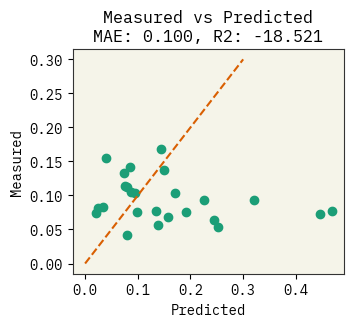

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

# examples = [f"{p}\t{f}" for p, f in zip(prompts, labels_f)]
# add prompt, peaks, areas, qy, completion to examples
examples = [f"{p}\t{c}\t{p1}\t{p2}\t{auc1}\t{auc2}\t{qy}" for p, c, p1, p2, auc1, auc2, qy in zip(prompts, labels_f, labels_peak1, labels_peak2, labels_auc1, labels_auc2, labels_qy)]

with open('Data/procedures.tsv', 'w') as f:
    f.write(f"prompt\tobj_f\tpeak1\tpeak2\tauc1\tauc2\tQY\n")
    f.write('\n'.join(examples))

# examples = [f"{p}\t{a1}\t{a2}\t{qy}\t{f}" for p, a1, a2, qy, f in zip(prompts, labels_auc1, labels_auc2, labels_qy, labels_f)]

# with open('Data/procedures.tsv', 'w') as f:
#     f.write(f"prompt\tauc1\tauc2\tQY\tobj_f\n")
#     f.write('\n'.join(examples))

mae = mean_absolute_error(pool_results['completion'], pool_results['prediction'])
r2 = r2_score(pool_results['completion'], pool_results['prediction'])

plt.plot(pool_results['prediction'], pool_results['completion'], 'o')
plt.xlabel('Predicted')
plt.ylabel('Measured')
plt.title(f"Measured vs Predicted\nMAE: {mae:.3f}, R2: {r2:.3f}")
plt.plot((0,0.3), (0,0.3), '--')
plt.show()

# Creating bolift pool

In [ ]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm):.3f} nm by {Dimension2(nm):.3f} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%):.3f}% recorded at 512 nm. {Nano_stock_vol(mL):.3f} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL):.3f} mL for each trial of doping. Silver acetate solution of {AgConc(M):.5f} M is made with {AgMass(mg):.3f} mg of silver acetate in {MeOH_vol(mL):.3f} mL of MeOH and {H2O_vol(mL):.3f} mL of water. {Doping(%):.3f} % Ag doping requires {AgSol(uL):.3f} uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C):.3f} oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

## Creating processed pool
Pool processed by Jorge's code (make_pool.ipynb)

In [ ]:
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

# Data created by make_pool.ipynb
df = pd.read_csv('Data/pool_processed.csv')

pool_list = []
for i, row in df.iterrows():
    pool_list.append(prompt_template.format(**row.to_dict()))

with open('Data/pool_processed.txt', 'w') as output:
    output.write("prompt;completion\n")
    output.write('\n'.join(pool_list))

# pool = bolift.Pool(pool_list)
# cloudpickle.dump(pool, open('Data/pool_processed.pkl', 'wb'))

# Data analysis

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

df = pd.read_csv('Data/fl_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[0, 0].plot(df['Wavelength(nm)'], df['Fluorescence'], label=group[0])
    axs[0, 1].plot(df['Wavelength(nm)'], df['Fluorescence_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)

df = pd.read_csv('Data/abs_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[1, 0].plot(df['Wavelength(nm)'], df['Absorbance'], label=group[0])
    axs[1, 1].plot(df['Wavelength(nm)'], df['Absorbance_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


In [ ]:
df = pd.read_csv('Data/processed_data.csv')

for r in BO_NLP.keys():
    # print(r)
    # print(BO_NLP[r])
    
    if not os.path.exists(f"Data/proposed_trials/NLP/{r}.txt"):
        continue

    with open(f"Data/proposed_trials/NLP/{r}.txt", 'r', encoding="utf-8-sig") as input:
        lines = input.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
        x, y = smooth_spectrum(x, y)
        fl_int_norm = [yi/max(y) for yi in y]
        fl_auc_total = get_area_under_peaks(x, y)
        peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
        fl_wvl, fl_int = x[:], y[:]

    abs_df = pd.read_csv(f"Data/proposed_trials/NLP/{r}.csv")
    abs_df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
    x, y = abs_df['nm'].astype(float).to_list(), abs_df[' A'].astype(float).to_list()
    x, y = smooth_spectrum(x, y)
    abs_int_norm = [yi/max(y) for yi in y]
    abs_auc_total = get_area_under_peaks(x, y)
    abs_wvl, abs_int = x[:], y[:]
    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
    abs_s = abs_df[abs_df['nm'] == 430][' A'].values[0]
    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2

    new_entry = pd.DataFrame({
        "Experiment": [r],
        'Peak1': [peaks[0]], 
        'Peak2': [peaks[1]], 
        'Area1': [areas[0]], 
        'Area2': [areas[1]],
        'QY': [qy],
        # 'Distance_peaks': [peaks[1]-peaks[0]],
        # 'ratioP2P1': [areas[1]/areas[0]],
        'Fl_Wavelengths': [str(fl_wvl)],
        'Fluorescence': [str(fl_int)],
        'Fluorescence_norm': [str(fl_int_norm)],
        'Abs_Wavelengths': [str(abs_wvl)],
        'Absorbance': [str(abs_int)],
        'Absorbance_norm': [str(abs_int_norm)]
    })
    df = pd.concat([df, new_entry], ignore_index=True)


df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

for r in BO_NLP.keys():
    try:
        sample = df[df['Experiment'] == r].iloc[0]
    except:
        continue
    results = pool_results[pool_results['Experiment'] == r].iloc[0]
    w = [float(a) for a in sample['Fl_Wavelengths'][1:-1].split(',')]
    i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]
    # w = [float(a) for a in sample['Abs_Wavelengths'][1:-1].split(',')]
    # i = [float(a) for a in sample['Absorbance'][1:-1].split(',')]

    plt.plot(w, i, color="C0")
    plt.title(f"{r}\n Predicted: {results['prediction']} <---> Measured: {results['completion']:.3f}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    # plt.ylabel("Absorbance")
plt.show()

In [ ]:
df[['Peak1', "Peak2", "Area1", "Area2", "QY"]].describe()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels_auc1 = df['Area1'].to_list()
labels_auc2 = df['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_auc1, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('Area1')
ax1.set_ylabel('Area2')

sns.histplot(labels_auc1, bins=20, label='Area1', ax=ax2, color='C1')
sns.histplot(labels_auc2, bins=20, label='Area2', ax=ax2, color='C2')
ax2.legend()

plt.tight_layout()
plt.show()

labels_qy = df[df['QY'] >= 0]['QY'].to_list()
labels_auc2 = df[df['QY'] >= 0]['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_qy, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('QY')
ax1.set_ylabel('Area2')

sns.histplot(labels_qy, bins=20, label='QY', ax=ax2, color='C1')
ax2.legend()

plt.tight_layout()
plt.show()



In [ ]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
import numpy as np
import base64
from io import BytesIO

x_name = "QY"
y_name = "Area2"

plotly_df = pd.DataFrame({
    f"{x_name}": df[x_name].tolist(),
    f"{y_name}": df[y_name].tolist(),
    "f": df[x_name] * df[y_name],
    "customdata": list(zip(
        df['Fl_Wavelengths'].tolist(), 
        df['Fluorescence'].tolist(),
        [
            f"{exp}:\nT={int(T)}C; doping={f_(d)}%; time={int(t)}s" if pd.notna(T) else f"Trial: {exp[1]} - Experiment: {exp[4]}"  
            for exp,T,d,t in df[['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']].values.tolist()
        ],
        # [
        #     # f"Reference F=QY*AUC2 \n QY={qy:.2f}, AUC2={auc2:.2f}, F={qy*auc2:.2f}" if pd.notna(T) else f"Trial: {exp[1]} - Experiment: {exp[4]} \n QY={qy:.2f}, AUC2={auc2:.2f}, F={qy*auc2:.2f}"  
        #     f""
        #     for exp,T,d,t,qy,auc2 in df[['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)', 'QY', 'Area2']].values.tolist()
        # ],
        ))
})
plotly_df = plotly_df[plotly_df['QY'] >= 0]
fig = px.scatter(plotly_df, x=x_name, y=y_name, color='f', custom_data=["customdata"])
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=10)

# Create dash app
app = dash.Dash(__name__)

# Create app layout to show dash graph
app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id="graph_interaction",
            figure=fig,
        )
    ], style={'width': '60%', 'display': 'inline-block'}),

    html.Div([
        html.Img(id='image', src='')
    ], style={'width': '30%', 'display': 'inline-block', 'padding': "20px"})
])

def plot_and_encode_image(data):
    wv = list(map(float, data[0].strip('[]').split(',')))
    fl = list(map(float, data[1].strip('[]').split(',')))
    title = data[2]
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    ax.xaxis.set_label_text("Wavelength (nm)")
    ax.yaxis.set_label_text("Fluorescence intensity (counts)")
    fig.suptitle(title)
    if "Reference" in title:
        ax.plot(wv, fl, color="C0")
    else:
        ax.plot(wv, fl, color="C0")
    plt.close(fig)
    
    # Convert plot to PNG image
    buf = BytesIO()
    fig.savefig(buf, format="png")
    
    # Encode PNG image to base64 string
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    return "data:image/png;base64,{}".format(data)

@app.callback(
    Output('image', 'src'),
    Input('graph_interaction', 'hoverData'))
def update_image(hoverData): 
    if hoverData:
        data_to_plot = hoverData["points"][0]["customdata"][0]
        return plot_and_encode_image(data_to_plot)
    else:
        raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=True)